In [ ]:
# for google colaboratory
from os import path
if 'google.colab' in str(get_ipython()):
    files = ['LLD-icon-sharp.hdf5', 'embed_train.zip']
    !pip install wget
    !pip install transformers
    import wget
    import shutil
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir Data
    for f in files:
        if not path.isfile('Data/' + f):
            if path.isfile('/content/drive/My Drive/Colab/AFRO/' + f):
                shutil.copy('/content/drive/My Drive/Colab/AFRO/' + f, 'Data')
            else:
                wget.download('https://data.vision.ee.ethz.ch/sagea/lld/data/' + f, 'Data')
    !unzip -q -n Data/embed_train.zip

In [2]:
# for debugging ------
from importlib import reload
import utils
utils = reload(utils)
from utils import lemmatize_and_clearing
# -------------------

import h5py
import numpy as np
import pandas as pd
from tqdm import notebook
import matplotlib.pyplot as plt
%matplotlib inline

import nltk

import torch
import torch.nn as nn
from IPython.display import clear_output
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

cuda


# Open data

## icon-sharp

In [3]:
files = h5py.File('Data/LLD-icon-sharp.hdf5', 'r')

In [4]:
files.keys()

<KeysViewHDF5 ['data', 'labels', 'meta_data']>

In [5]:
clusters = files['labels/resnet/rc_128']
names = files['meta_data/names'][()].astype(str)
images = files['data']

# Work with labels

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
lem_names =  map(lemmatize_and_clearing, names)

## Download bert files and berting all that is possible

In [ ]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# tok_names = tokenizer(list(lem_names), padding=True, return_tensors="pt")

# model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
# model = model.to(device)

# batch_size = 10
# dataloader = DataLoader(tok_names['input_ids'], batch_size=batch_size)

# embed_and_write_file(dataloader, model, device, 'embed_train.csv')

In [ ]:
df = pd.read_csv('Data/embed_train.csv', header=None)

In [1]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        dim = 3

        self.features_to_image = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4*dim,
                               kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 3 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(3 * dim),
            nn.Conv2d(3 * dim, 2*dim, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2*dim),
            nn.Conv2d(2*dim, dim, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        return self.features_to_image(input_data)

NameError: name 'nn' is not defined

In [ ]:
ix = np.arange(len(df))
# np.random.shuffle(ix)
tr, val, ts = np.split(ix, [len(df)//2, len(df)//2 + len(df)//4])
print(len(tr), len(val), len(ts))

In [ ]:
batch_size = 20
train_dataloader = DataLoader(list(zip(df.iloc[tr].values, images[tr])), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(list(zip(df.iloc[val].values, images[val])), batch_size=batch_size)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    X_val = torch.as_tensor(X_val, dtype=torch.float, device=device)
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        with notebook.tqdm(total=len(data_tr)) as progress_bar:
            for step, (X_batch, Y_batch) in enumerate(data_tr):
                # data to device
                X_batch = torch.as_tensor(X_batch, dtype=torch.float, device=device)
                Y_batch = Y_batch.to(device) / 255.
                # set parameter gradients to zero
                opt.zero_grad()
                # forward
                Y_pred = model(X_batch.view(-1, 3, 16, 16))
                loss = loss_fn(Y_batch, Y_pred) # forward-pass
                avg_loss += loss.item()
                loss = loss.backward() # backward-pass
                opt.step()  # update weights
                progress_bar.set_description('loss: %f' % (avg_loss/(step+1)))
                progress_bar.update()

            # calculate loss to show the user
        avg_loss = avg_loss / len(data_tr)
        # print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.view(-1, 3, 16, 16)).detach().cpu().numpy() # detach and put into cpu
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.moveaxis(Y_val[k].numpy(), 0, 2))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(np.moveaxis(Y_hat[k], 0, 2))
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

In [ ]:
gen = Generator()
gen = gen.to(device)

In [ ]:
max_epochs = 1
loss_func = nn.MSELoss()
optim = torch.optim.Adam(gen.parameters(), lr=1e-3)
train(gen, optim, loss_func, max_epochs, train_dataloader, val_dataloader)

# Create text and add to icon

In [86]:
# custom module ---
from importlib import reload 
import utils
utils = reload(utils)
from utils import add_text_to_img, text_to_pic_transform, get_examples, add_logo_to_pic
# ------------------
import cv2
import os
from PIL import Image

In [105]:
images = []
lesions = []
root = 'Data'
for root, dirs, files in os.walk(os.path.join(root, 'dataset_for_afro')):
    for file in files:
        images.append(np.asarray(Image.open(os.path.join(root, file)))[np.newaxis])

In [106]:
afro_data = np.vstack(images)

In [107]:
afro_data.shape

(150, 32, 32, 3)

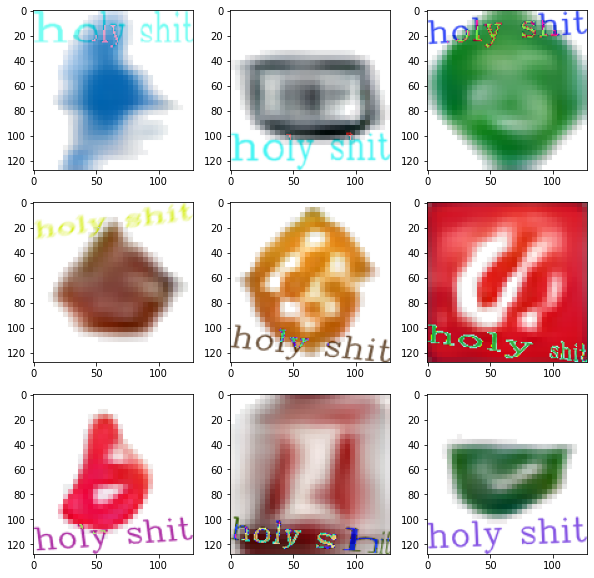

In [108]:
grid_size = 3
_, ax = plt.subplots(ncols=grid_size, nrows=grid_size, figsize=(10, 10))
for i in range(grid_size**2):
    img = images[np.random.randint(len(images))].squeeze(0)
#     img = np.moveaxis(img, 0, -1)
    
    join_img = add_text_to_img('holy shit', img)
    ax[i//grid_size, i%grid_size].imshow(join_img)

In [68]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(255, 255, 255))

In [70]:
man = np.array(Image.open('img/man.jpg'))

(417, 626, 3)


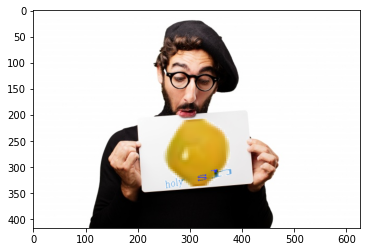

In [72]:
plt.imshow(add_logo_to_pic(join_img, pic='img/man.jpg', coord=(205, 245), angle=-4))

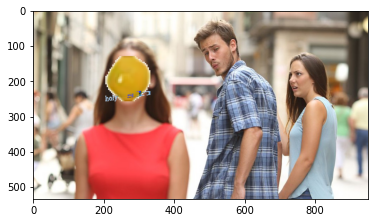

In [104]:
plt.imshow(get_examples(join_img, 'bad_guy'))

# Style transfer

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
(text_to_pic_transform('Holy shit') / 255).shape

In [ ]:
pic = np.moveaxis(images[np.random.randint(len(images))], 0, -1)
text = text_to_pic_transform('Holy shit') / 255

res_pic = cv2.resize(pic, dsize=(128, 128), interpolation=cv2.INTER_AREA)
res_text = cv2.resize(text, dsize=(128, 128), interpolation=cv2.INTER_AREA)

res_pic = np.moveaxis(res_pic, -1, 0)
res_text = np.moveaxis(res_text, -1, 0)

style_img = torch.as_tensor(res_pic, device=device).unsqueeze(0)
content_img = torch.as_tensor(res_text, device=device, dtype=torch.float32).unsqueeze(0)

style_img.shape, content_img.shape

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1e+5, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

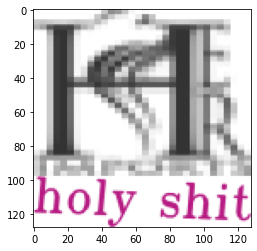

# Style transfer

In [442]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [444]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [458]:
(text_to_pic_transform('Holy shit') / 255).shape

(1024, 1024, 3)

In [518]:
pic = np.moveaxis(images[np.random.randint(len(images))], 0, -1)
text = text_to_pic_transform('Holy shit') / 255

res_pic = cv2.resize(pic, dsize=(128, 128), interpolation=cv2.INTER_AREA)
res_text = cv2.resize(text, dsize=(128, 128), interpolation=cv2.INTER_AREA)

res_pic = np.moveaxis(res_pic, -1, 0)
res_text = np.moveaxis(res_text, -1, 0)

style_img = torch.as_tensor(res_pic, device=device).unsqueeze(0)
content_img = torch.as_tensor(res_text, device=device, dtype=torch.float32).unsqueeze(0)

style_img.shape, content_img.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

In [519]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

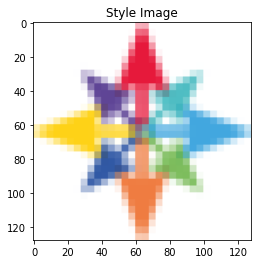

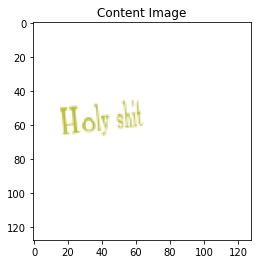

In [520]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [521]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [522]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [523]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [524]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [525]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [526]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

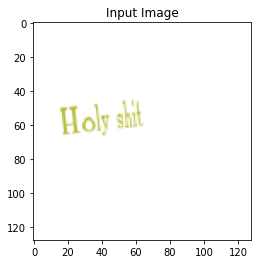

In [547]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [548]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [549]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1e+5, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\svetl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 158734206631936.000000 Content Loss: 217.196289

run [100]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [150]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [200]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [250]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [300]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [350]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [400]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [450]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [500]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [550]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [600]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [650]:
Style Loss : 158731723603968.000000 Content Loss: 333.387085

run [700]:
Style Loss : 158731723603968.000000 Conte

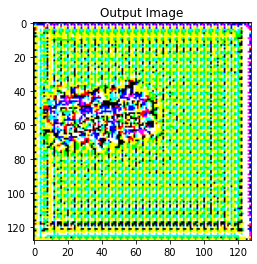

In [550]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()